In [126]:
import mne
import os
import numpy as np

In [192]:
import pandas as pd

folder_name = "digit"
root_folder = f"./data/emotiv/custom/{folder_name}"

dfs = {
    
}

pad = 600

for folder in os.listdir(root_folder):
    # check if folder is a directory
    isFolder = os.path.isdir(os.path.join(root_folder, folder))
    folder_name = folder
    dfs[folder_name] = []
    if isFolder:
        for file in os.listdir(os.path.join(root_folder, folder)):
            print(file)
            if file.endswith(".csv"):
                print("Processing file: ", file)
                df = pd.read_csv(os.path.join(root_folder, folder, file), header=1)
                # merge with previous dataframes
                # remove the fist 256 rows since there might be some noise in the beginning
                df = df[pad:-pad]
                dfs[folder_name].append(df) 
                

3nine_EPOCX_243632_2024.11.20T22.15.58.05.00.md.csv
Processing file:  3nine_EPOCX_243632_2024.11.20T22.15.58.05.00.md.csv
4nine_EPOCX_243632_2024.11.20T22.16.54.05.00.md.csv
Processing file:  4nine_EPOCX_243632_2024.11.20T22.16.54.05.00.md.csv
1nine_EPOCX_243632_2024.11.20T22.14.14.05.00.md.csv
Processing file:  1nine_EPOCX_243632_2024.11.20T22.14.14.05.00.md.csv
nine3_EPOCX_243632_2024.11.20T01.20.37.05.00.md.csv
Processing file:  nine3_EPOCX_243632_2024.11.20T01.20.37.05.00.md.csv
2nine_EPOCX_243632_2024.11.20T22.15.09.05.00.md.csv
Processing file:  2nine_EPOCX_243632_2024.11.20T22.15.09.05.00.md.csv
nine2_EPOCX_243632_2024.11.20T00.53.45.05.00.md.csv
Processing file:  nine2_EPOCX_243632_2024.11.20T00.53.45.05.00.md.csv
nine_EPOCX_243632_2024.11.20T00.53.06.05.00.md.csv
Processing file:  nine_EPOCX_243632_2024.11.20T00.53.06.05.00.md.csv
nine4_EPOCX_243632_2024.11.20T01.21.26.05.00.md.csv
Processing file:  nine4_EPOCX_243632_2024.11.20T01.21.26.05.00.md.csv
2zero_EPOCX_243632_2024.11

In [193]:
eeg_columns = ["EEG.AF3", "EEG.F7", "EEG.F3", "EEG.FC5", "EEG.T7", "EEG.P7", "EEG.O1", "EEG.O2", "EEG.P8", "EEG.T8", "EEG.FC6", "EEG.F4", "EEG.F8", "EEG.AF4"]

In [194]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, lfilter

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    # y = filtfilt(b, a, data)
    return y

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

def compute_stft_for_segment(segment, fs, n_fft=256, hop_length=128):
    """
    Compute STFT for a multi-channel EEG segment.
    Args:
        segment: 2D array of shape (256, 14), where rows are time points and columns are channels.
        fs: Sampling frequency in Hz.
        n_fft: Number of FFT points.
        hop_length: Number of overlapping samples between windows.
    Returns:
        stft_results: 3D array of shape (n_channels, n_freq_bins, n_time_frames)
                      containing the magnitude spectrograms for each channel.
    """
    n_channels = segment.shape[1]
    stft_results = pd.DataFrame()
    
    
    for ch in range(n_channels):
        # Compute STFT for each channel
        _, _, Zxx = stft(segment[:, ch], fs, nperseg=n_fft, noverlap=hop_length)
        
        magnitude = np.abs(Zxx)
        magnitude_db = 20 * np.log10(magnitude + 1e-6)  # Add small value to avoid log(0)
        
        # merge with previous dataframes
        stft_results = pd.concat([stft_results, pd.DataFrame(magnitude_db)], axis=1)
    
    
    return np.array(stft_results)  # Shape: (n_channels, n_freq_bins, n_time_frames)


In [196]:
train = {}

lowcut = 0.5
highcut = 30
fs = 128

for key in dfs.keys():
    train[key] = []
    min = np.inf
    max = -np.inf
    for df in dfs[key]:
        # split the data by 256 samples
        for i in range(0, len(df), 256//2):
            if i + 256 < len(df):
                data = df[i:i+256][eeg_columns].values
                # apply bandpass filter
                data = bandpass_filter(data, lowcut, highcut, fs)
                extracted = compute_stft_for_segment(data, fs)
                if extracted.min() < min:
                    min = extracted.min()
                if extracted.max() > max:
                    max = extracted.max()
                train[key].append(extracted)
    # normalize the data for consistency
    train[key] = (train[key] - min) / (max - min)
    # change to cnn input
    train[key] = np.array(train[key])
    
    # add a 1 channel dimension
    train[key] = train[key].reshape(train[key].shape[0], 1, train[key].shape[1], train[key].shape[2])
    
    # num_samples, num_channels, height, width = train[key].shape
    print(train[key].shape)
    # train[key] = train[key].reshape(num_samples, num_channels, height, width)
    # merge the 14 channels in to one picture

# get the minimum length of train data
min_length = np.inf
for key in train.keys():
    if train[key].shape[0] < min_length:
        min_length = train[key].shape[0]

# make everything min_length
for key in train.keys():
    train[key] = train[key][:min_length]

for key in train.keys():
    print(key, train[key].shape)

# save min and max values
np.save("min_stft.npy", min)
np.save("max_stft.npy", max)

(255, 1, 129, 42)
(264, 1, 129, 42)
(270, 1, 129, 42)
(301, 1, 129, 42)
(281, 1, 129, 42)
(231, 1, 129, 42)
(257, 1, 129, 42)
(321, 1, 129, 42)
(313, 1, 129, 42)
(263, 1, 129, 42)
9 (231, 1, 129, 42)
0 (231, 1, 129, 42)
7 (231, 1, 129, 42)
6 (231, 1, 129, 42)
1 (231, 1, 129, 42)
8 (231, 1, 129, 42)
4 (231, 1, 129, 42)
3 (231, 1, 129, 42)
2 (231, 1, 129, 42)
5 (231, 1, 129, 42)


In [197]:
# train["0"].shape # we treat them as on channel image

In [198]:
import pandas as pd

# Combine data from the dictionary
X = []
y = []
labels = []

for label, data in train.items():
    X.append(data)  # Add all the spectrograms
    y.extend([label] * data.shape[0])  # Extend labels for each sample
    # create a mapping of the labels
    labels.append(label)
    
# use categorical encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels)

# Convert to numpy arrays
X = np.concatenate(X, axis=0)
print(X.shape)
y = np.array(y)
# change y to categorical
y = le.transform(y)

print(y)
# labels count
print(len(le.classes_))

outputs = len(le.classes_)

(2310, 1, 129, 42)
[9 9 9 ... 5 5 5]
10


In [199]:
y

array([9, 9, 9, ..., 5, 5, 5])

In [200]:
X.shape

(2310, 1, 129, 42)

In [201]:
from sklearn.model_selection import train_test_split

print("X shape:", X.shape)
print("y shape:", y.shape)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

X shape: (2310, 1, 129, 42)
y shape: (2310,)
Training set shape: (1617, 1, 129, 42)
Validation set shape: (346, 1, 129, 42)
Test set shape: (347, 1, 129, 42)


In [202]:
import torch
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, data, labels):
        """
        Args:
            data: A NumPy array of shape (num_samples, channels, height, width).
            labels: A NumPy array of shape (num_samples,) with classification labels.
        """
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert data to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]  # Shape: (channels, height, width)
        y = self.labels[idx]  # Shape: ()
        return x, y

# Create PyTorch Datasets
train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)


In [203]:
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(EEGCNN, self).__init__()
        # Group 1 (G1): Time-frequency convolution
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=(3, 3), stride=1, padding=(1, 1))  # G1 Conv
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for G1
        self.relu1 = nn.ReLU()

        # Group 2 (G2): Spatial convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=(1, 1))  # G2 Conv
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for G2
        self.relu2 = nn.ReLU()

        # MaxPool layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # Reduces both height and width

        # Fully connected layers
        self.flattened_size = self._get_flattened_size(input_channels, 129, 42)
        self.fc1 = nn.Linear(self.flattened_size, 128)  # Fully connected layer
        self.dropout = nn.Dropout(0.1)  # Dropout for regularization
        self.fc2 = nn.Linear(128, num_classes)  # Output layer for classification
        
        
    
    def _get_flattened_size(self, input_channels, height, width):
        with torch.no_grad():
            x = torch.zeros(1, input_channels, height, width)
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.pool(x)
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.pool(x)
            return x.view(1, -1).size(1)
    
    def forward(self, x):
        # Group 1 (G1): Time-frequency convolution
        x = self.relu1(self.bn1(self.conv1(x)))

        # MaxPool
        x = self.pool(x)

        # Group 2 (G2): Spatial convolution
        x = self.relu2(self.bn2(self.conv2(x)))

        # MaxPool
        x = self.pool(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No softmax here; handled by CrossEntropyLoss
        return x

# Define model
input_channels = X_train.shape[1]  # Number of channels in the input data
num_classes = len(le.classes_)  # Number of classes
print(input_channels, num_classes)
model = EEGCNN(input_channels, num_classes)
print(model)

1 10
EEGCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20480, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [204]:
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train_model(model, train_loader, val_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss, val_acc = validate_model(model, val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Validation function
def validate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return val_loss / len(val_loader), correct / total

# Train the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {correct / total:.4f}")

In [206]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

train_model(model, train_loader, val_loader, num_epochs=10)
test_model(model, test_loader)

Epoch 1/10, Loss: 86.2582, Val Loss: 1.5192, Val Acc: 0.3410
Epoch 2/10, Loss: 69.7186, Val Loss: 1.2482, Val Acc: 0.6214
Epoch 3/10, Loss: 62.3040, Val Loss: 1.2013, Val Acc: 0.4798
Epoch 4/10, Loss: 57.6534, Val Loss: 1.1557, Val Acc: 0.4595
Epoch 5/10, Loss: 54.8148, Val Loss: 1.0531, Val Acc: 0.5896
Epoch 6/10, Loss: 52.5090, Val Loss: 1.0189, Val Acc: 0.5954
Epoch 7/10, Loss: 50.8467, Val Loss: 0.9866, Val Acc: 0.6590
Epoch 8/10, Loss: 49.1322, Val Loss: 1.1064, Val Acc: 0.5116
Epoch 9/10, Loss: 49.0771, Val Loss: 0.9205, Val Acc: 0.6561
Epoch 10/10, Loss: 46.5279, Val Loss: 0.9218, Val Acc: 0.6387
Test Accuracy: 0.5994


In [207]:
# change index to label
le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

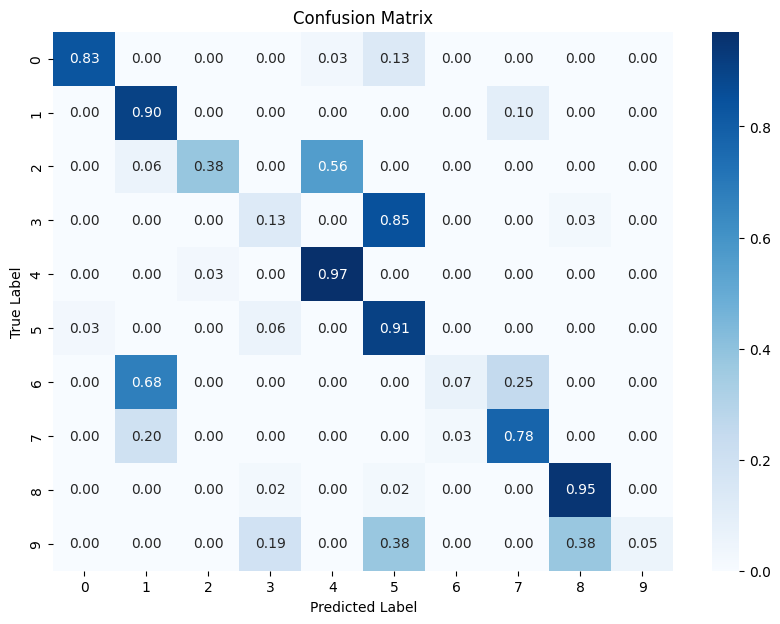

In [208]:
# draw confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Get predictions
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, le.classes_)

In [209]:
# save the model
torch.save(model.state_dict(), "model_cnn.pth")